# XGBoost:

Trains XGBoost from annual to monthly climate frequencies.

## Setting up:
### Imports:

In [1]:
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import re
from pathlib import Path
import xarray as xr
import warnings
import re
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator

warnings.filterwarnings("ignore")

In [2]:
from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *

from scripts.PDD_model_modules import *
from scripts.PDD_model_calibration import *
from scripts.PDD_helpers import *

%load_ext autoreload
%autoreload 2

### Constants:

In [3]:
# set seed everywhere:
seed_all(SEED)

param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': np.arange(50, 300, 15),
    'max_depth': np.arange(3, 10, 1),
}
INPUT_TYPE = "MeteoSuisse"

KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
    FOLD = 'kfold'
else:
    NUM_FOLDS = 1
    FOLD = 'single_fold'

path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

In [4]:
color_palette = sns.color_palette("husl", len(MONTH_VAL.keys()))
palette = {}
for ind in MONTH_VAL.keys():
    palette[MONTH_VAL[ind]] = color_palette[ind - 1]

## Pre-processing:

In [5]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())

# Select stakes that have at least 20 years of measurements
glStakes_20years, glStakes_20years_sorted, glStakes_20years_all = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type=INPUT_TYPE,
    N=20)
print('After preprocessing:\n----\nNumber of glaciers:',
      len(glStakes_20years.keys()))
num_stakes = 0
for gl in glStakes_20years.keys():
    num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', num_stakes)

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
1991 2023
1991 2023
1991 2023
2011 2023
2004 2023
2004 2023
2004 2023
2004 2023
2005 2023
2009 2023
2009 2023
1961 2023
1961 2023
2006 2023
2006 2023
2006 2023
1955 2023
Missing years: [2016, 2017, 2018, 2019, 2020]
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
2006 2021
2006 2021
2009 2023
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
2001 2023
2012 2023
2012 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023
After preprocessing:
----
Number of glaciers: 13
Number of stakes: 28


In [6]:
glStakes_20years_all

['basodino_P5',
 'basodino_P8',
 'basodino_P10',
 'gries_P32',
 'gries_P112',
 'schwarzberg_P2',
 'aletsch_P5',
 'aletsch_P0',
 'aletsch_P9',
 'aletsch_P10',
 'aletsch_P3',
 'limmern_P2',
 'limmern_P1',
 'limmern_P3',
 'clariden_U',
 'clariden_L',
 'allalin_P1',
 'silvretta_P9',
 'silvretta_BO',
 'silvretta_BU',
 'hohlaub_P2',
 'pers_P24',
 'corbassiere_B2',
 'plattalva_P10',
 'plattalva_P11',
 'gietro_P1',
 'gietro_P3',
 'gietro_P5']

## Train XGBoost:

### Annual:

1966 2023


Text(0.5, 0.98, 'gietro_P1')

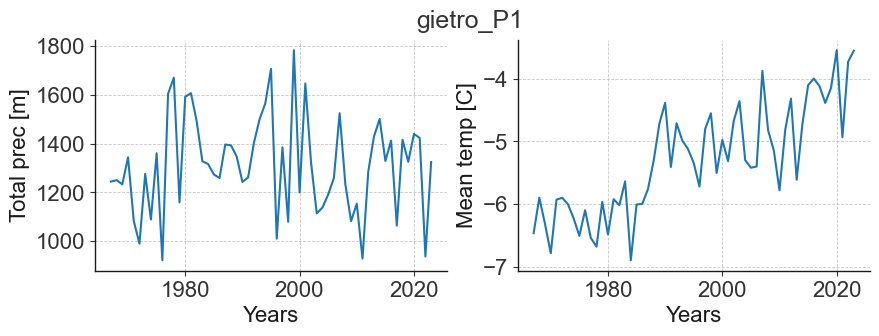

In [7]:
# Example of climate data from MeteoSuisse
stake = glStakes_20years[gl][0]
stakeName = re.split(".csv", stake)[0][:-3]
df_stake = read_stake_csv(path_glacattr, stake, COI)

fileName = re.split(".csv", stake)[0]
xr_temppr = xr.open_dataset(path_MS + f"{fileName}_full.nc").sortby("time")
begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year

df_stake_cut = cutStake(df_stake, begin_xr, end_xr)

target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]

df_yearly = createInputDF_year(df_stake_cut, xr_temppr).reset_index()
df_yearly['avg_temperature'] = df_yearly['avg_temperature']
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
sns.lineplot(df_yearly, x='index', y='tot_precipitation', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Total prec [m]')

ax = plt.subplot(1, 2, 2)
sns.lineplot(df_yearly, x='index', y='avg_temperature', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Mean temp [C]')

plt.suptitle(stakeName)

In [8]:
RUN = True
today = date.today()
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='annual',
               mb_match='annual',
               kfold=KFOLD,
               input_type=INPUT_TYPE)

var_xg_annual, metrics_annual = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/annual/t2m_tp/match_annual/',glStakes_20years_all)

Creating path: ../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/annual/t2m_tp/match_annual/
Matching annual MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
1991 2023


### Half year:

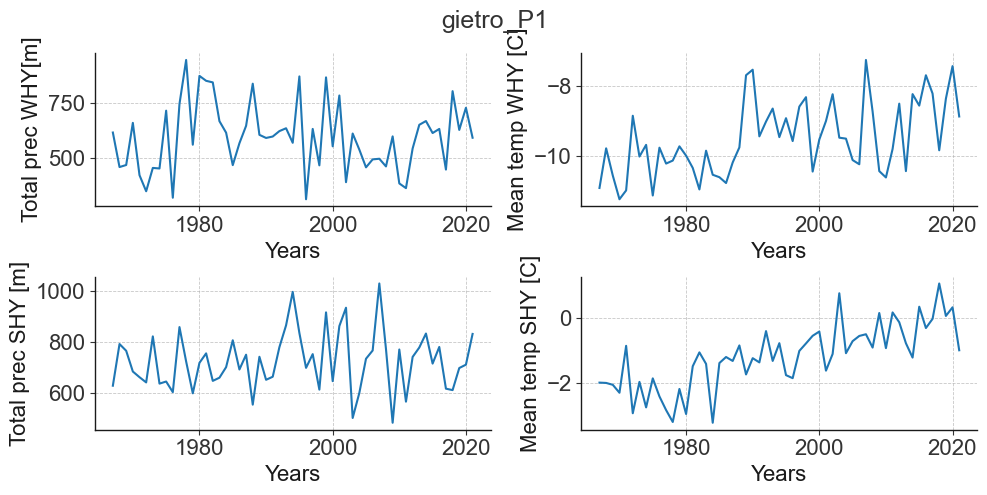

In [ ]:
df_halfyearly = createInputDF_halfyear(df_stake_cut, xr_temppr).reset_index()
df_halfyearly['temp_WHY'] = df_halfyearly['temp_WHY']
df_halfyearly['temp_SHY'] = df_halfyearly['temp_SHY']

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(2, 2, 1)
sns.lineplot(df_halfyearly, x='index', y='prec_WHY', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Total prec WHY[m]')
ax = plt.subplot(2, 2, 2)
sns.lineplot(df_halfyearly, x='index', y='temp_WHY', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Mean temp WHY [C]')

ax = plt.subplot(2, 2, 3)
sns.lineplot(df_halfyearly, x='index', y='prec_SHY', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Total prec SHY [m]')
ax = plt.subplot(2, 2, 4)
sns.lineplot(df_halfyearly, x='index', y='temp_SHY', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Mean temp SHY [C]')
plt.suptitle(stakeName)

plt.tight_layout()

In [ ]:
RUN = True
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='half_year',
               mb_match='annual',
               kfold=KFOLD,
               input_type=INPUT_TYPE)
var_xg_half, metrics_half = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/half_year/t2m_tp/match_annual/',glStakes_20years_all)

Creating path: ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Matching annual MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
dictionary var_basodino_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: basodino_P8
-------------
dictionary var_basodino_P8.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: basodino_P10
-------------
dictionary var_basodino_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: gries_P32
-------------
dictionary var_gries_P32.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: gries_P112
-------------
dictionary var_gries_P112.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: schwarzberg_P2
-------------
dictionary var_schwarzberg_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/5 [00:00<?, ?it/s]

Running XGB for stake: aletsch_P5
-------------
dictionary var_aletsch_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: aletsch_P0
-------------
dictionary var_aletsch_P0.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: aletsch_P9
-------------
dictionary var_aletsch_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: aletsch_P10
-------------
dictionary var_aletsch_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: aletsch_P3
-------------
dictionary var_aletsch_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: limmern_P2
-------------
dictionary var_limmern_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: limmern_P1
-------------
dictionary var_limmern_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: limmern_P3
-------------
dictionary var_limmern_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: clariden_U
-------------
dictionary var_clariden_U.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: clariden_L
-------------
dictionary var_clariden_L.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: allalin_P1
-------------
dictionary var_allalin_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: silvretta_P9
-------------
dictionary var_silvretta_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: silvretta_BO
-------------
dictionary var_silvretta_BO.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: silvretta_BU
-------------
dictionary var_silvretta_BU.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: hohlaub_P2
-------------
dictionary var_hohlaub_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: pers_P24
-------------
dictionary var_pers_P24.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: corbassiere_B2
-------------
dictionary var_corbassiere_B2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: plattalva_P10
-------------
dictionary var_plattalva_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: plattalva_P11
-------------
dictionary var_plattalva_P11.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: gietro_P1
-------------
dictionary var_gietro_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: gietro_P3
-------------
dictionary var_gietro_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/
Running XGB for stake: gietro_P5
-------------
dictionary var_gietro_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/half_year/t2m_tp/match_annual/


### Seasonal:

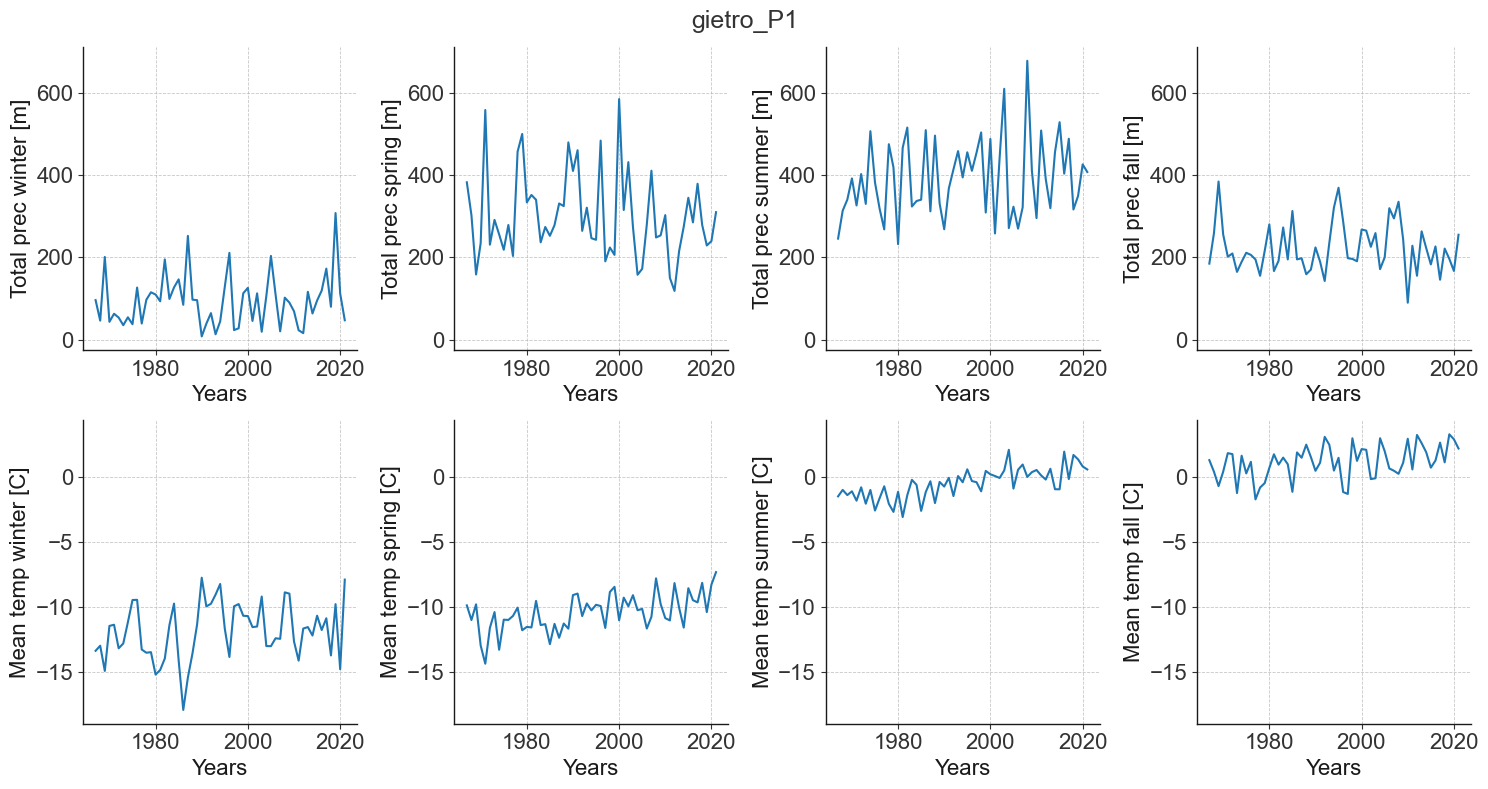

In [ ]:
df_seasonal = createInputDF_seasonal(df_stake_cut,
                                     xr_temppr,
                                     input_type=INPUT_TYPE).reset_index()
df_seasonal['temp_winter'] = df_seasonal['temp_winter']
df_seasonal['temp_spring'] = df_seasonal['temp_spring']
df_seasonal['temp_fall'] = df_seasonal['temp_fall']
df_seasonal['temp_summer'] = df_seasonal['temp_summer']

fig = plt.figure(figsize=(15, 8))
ax1 = plt.subplot(2, 4, 1)
sns.lineplot(df_seasonal, x='index', y='prec_winter', ax=ax1)
ax1.set_xlabel('Years')
ax1.set_ylabel('Total prec winter [m]')
ax2 = plt.subplot(2, 4, 2, sharey=ax1)
sns.lineplot(df_seasonal, x='index', y='prec_spring', ax=ax2)
ax2.set_xlabel('Years')
ax2.set_ylabel('Total prec spring [m]')

ax3 = plt.subplot(2, 4, 3, sharey=ax1)
sns.lineplot(df_seasonal, x='index', y='prec_summer', ax=ax3)
ax3.set_xlabel('Years')
ax3.set_ylabel('Total prec summer [m]')
ax4 = plt.subplot(2, 4, 4, sharey=ax1)
sns.lineplot(df_seasonal, x='index', y='prec_fall', ax=ax4)
ax4.set_xlabel('Years')
ax4.set_ylabel('Total prec fall [m]')
plt.suptitle(stakeName)

ax5 = plt.subplot(2, 4, 5)
sns.lineplot(df_seasonal, x='index', y='temp_winter', ax=ax5)
ax5.set_xlabel('Years')
ax5.set_ylabel('Mean temp winter [C]')
ax6 = plt.subplot(2, 4, 6, sharey=ax5)
sns.lineplot(df_seasonal, x='index', y='temp_spring', ax=ax6)
ax6.set_xlabel('Years')
ax6.set_ylabel('Mean temp spring [C]')

ax7 = plt.subplot(2, 4, 7, sharey=ax5)
sns.lineplot(df_seasonal, x='index', y='temp_summer', ax=ax7)
ax7.set_xlabel('Years')
ax7.set_ylabel('Mean temp summer [C]')
ax8 = plt.subplot(2, 4, 8, sharey=ax5)
sns.lineplot(df_seasonal, x='index', y='temp_fall', ax=ax8)
ax8.set_xlabel('Years')
ax8.set_ylabel('Mean temp fall [C]')

plt.tight_layout()

In [ ]:
RUN = True
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='seasonal',
               mb_match='annual',
               kfold=KFOLD,
               input_type=INPUT_TYPE)
var_xg_seasonal, metrics_seasonal = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/seasonal/t2m_tp/match_annual/',glStakes_20years_all)

Creating path: ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Matching annual MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
dictionary var_basodino_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: basodino_P8
-------------
dictionary var_basodino_P8.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: basodino_P10
-------------
dictionary var_basodino_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: gries_P32
-------------
dictionary var_gries_P32.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: gries_P112
-------------
dictionary var_gries_P112.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: schwarzberg_P2
-------------
dictionary var_schwarzberg_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/5 [00:00<?, ?it/s]

Running XGB for stake: aletsch_P5
-------------
dictionary var_aletsch_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: aletsch_P0
-------------
dictionary var_aletsch_P0.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: aletsch_P9
-------------
dictionary var_aletsch_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: aletsch_P10
-------------
dictionary var_aletsch_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: aletsch_P3
-------------
dictionary var_aletsch_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: limmern_P2
-------------
dictionary var_limmern_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: limmern_P1
-------------
dictionary var_limmern_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: limmern_P3
-------------
dictionary var_limmern_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: clariden_U
-------------
dictionary var_clariden_U.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: clariden_L
-------------
dictionary var_clariden_L.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: allalin_P1
-------------
dictionary var_allalin_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: silvretta_P9
-------------
dictionary var_silvretta_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: silvretta_BO
-------------
dictionary var_silvretta_BO.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: silvretta_BU
-------------
dictionary var_silvretta_BU.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: hohlaub_P2
-------------
dictionary var_hohlaub_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: pers_P24
-------------
dictionary var_pers_P24.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: corbassiere_B2
-------------
dictionary var_corbassiere_B2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: plattalva_P10
-------------
dictionary var_plattalva_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: plattalva_P11
-------------
dictionary var_plattalva_P11.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: gietro_P1
-------------
dictionary var_gietro_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: gietro_P3
-------------
dictionary var_gietro_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/
Running XGB for stake: gietro_P5
-------------
dictionary var_gietro_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/seasonal/t2m_tp/match_annual/


### Monthly: different MB matches

#### Match only winter MB:

In [ ]:
RUN = True
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='monthly',
               kfold=KFOLD,
               mb_match='winter',
               input_type=INPUT_TYPE)

var_xg_monthly_w, metrics_monthly_w = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_winter/',glStakes_20years_all)

Creating path: ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Matching winter MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
dictionary var_basodino_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: basodino_P8
-------------
dictionary var_basodino_P8.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: basodino_P10
-------------
dictionary var_basodino_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: gries_P32
-------------
dictionary var_gries_P32.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: gries_P112
-------------
dictionary var_gries_P112.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: schwarzberg_P2
-------------
dictionary var_schwarzberg_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/5 [00:00<?, ?it/s]

Running XGB for stake: aletsch_P5
-------------
dictionary var_aletsch_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: aletsch_P0
-------------
dictionary var_aletsch_P0.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: aletsch_P9
-------------
dictionary var_aletsch_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: aletsch_P10
-------------
dictionary var_aletsch_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: aletsch_P3
-------------
dictionary var_aletsch_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: limmern_P2
-------------
dictionary var_limmern_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: limmern_P1
-------------
dictionary var_limmern_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: limmern_P3
-------------
dictionary var_limmern_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: clariden_U
-------------
dictionary var_clariden_U.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: clariden_L
-------------
dictionary var_clariden_L.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: allalin_P1
-------------
dictionary var_allalin_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: silvretta_P9
-------------
dictionary var_silvretta_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: silvretta_BO
-------------
dictionary var_silvretta_BO.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: silvretta_BU
-------------
dictionary var_silvretta_BU.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: hohlaub_P2
-------------
dictionary var_hohlaub_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: pers_P24
-------------
dictionary var_pers_P24.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: corbassiere_B2
-------------
dictionary var_corbassiere_B2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: plattalva_P10
-------------
dictionary var_plattalva_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: plattalva_P11
-------------
dictionary var_plattalva_P11.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: gietro_P1
-------------
dictionary var_gietro_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: gietro_P3
-------------
dictionary var_gietro_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/
Running XGB for stake: gietro_P5
-------------
dictionary var_gietro_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_winter/


#### Match annual with extra winter MB in input:

In [ ]:
RUN = True
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='monthly',
               kfold=KFOLD,
               mb_match='annual+winter',
               input_type=INPUT_TYPE)

var_xg_monthly_aw, metrics_monthly_aw = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual_winter/',glStakes_20years_all)

Creating path: ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Matching annual+winter MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
dictionary var_basodino_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: basodino_P8
-------------
dictionary var_basodino_P8.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: basodino_P10
-------------
dictionary var_basodino_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: gries_P32
-------------
dictionary var_gries_P32.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: gries_P112
-------------
dictionary var_gries_P112.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: schwarzberg_P2
-------------
dictionary var_schwarzberg_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/5 [00:00<?, ?it/s]

Running XGB for stake: aletsch_P5
-------------
dictionary var_aletsch_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: aletsch_P0
-------------
dictionary var_aletsch_P0.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: aletsch_P9
-------------
dictionary var_aletsch_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: aletsch_P10
-------------
dictionary var_aletsch_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: aletsch_P3
-------------
dictionary var_aletsch_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: limmern_P2
-------------
dictionary var_limmern_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: limmern_P1
-------------
dictionary var_limmern_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: limmern_P3
-------------
dictionary var_limmern_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: clariden_U
-------------
dictionary var_clariden_U.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: clariden_L
-------------
dictionary var_clariden_L.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: allalin_P1
-------------
dictionary var_allalin_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: silvretta_P9
-------------
dictionary var_silvretta_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: silvretta_BO
-------------
dictionary var_silvretta_BO.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: silvretta_BU
-------------
dictionary var_silvretta_BU.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: hohlaub_P2
-------------
dictionary var_hohlaub_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: pers_P24
-------------
dictionary var_pers_P24.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: corbassiere_B2
-------------
dictionary var_corbassiere_B2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: plattalva_P10
-------------
dictionary var_plattalva_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: plattalva_P11
-------------
dictionary var_plattalva_P11.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: gietro_P1
-------------
dictionary var_gietro_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: gietro_P3
-------------
dictionary var_gietro_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/
Running XGB for stake: gietro_P5
-------------
dictionary var_gietro_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual_winter/


#### Match annual MB:

In [ ]:
RUN = True
if RUN:
    runXGBoost(glStakes_20years,
               param_grid,
               temporalFreq='monthly',
               kfold=KFOLD,
               mb_match='annual',
               input_type=INPUT_TYPE)

var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/',glStakes_20years_all)

Creating path: ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Matching annual MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: basodino_P5
-------------
dictionary var_basodino_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: basodino_P8
-------------
dictionary var_basodino_P8.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: basodino_P10
-------------
dictionary var_basodino_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: gries_P32
-------------
dictionary var_gries_P32.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: gries_P112
-------------
dictionary var_gries_P112.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: schwarzberg_P2
-------------
dictionary var_schwarzberg_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/5 [00:00<?, ?it/s]

Running XGB for stake: aletsch_P5
-------------
dictionary var_aletsch_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: aletsch_P0
-------------
dictionary var_aletsch_P0.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: aletsch_P9
-------------
dictionary var_aletsch_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: aletsch_P10
-------------
dictionary var_aletsch_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: aletsch_P3
-------------
dictionary var_aletsch_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: limmern_P2
-------------
dictionary var_limmern_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: limmern_P1
-------------
dictionary var_limmern_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: limmern_P3
-------------
dictionary var_limmern_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: clariden_U
-------------
dictionary var_clariden_U.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: clariden_L
-------------
dictionary var_clariden_L.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: allalin_P1
-------------
dictionary var_allalin_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: silvretta_P9
-------------
dictionary var_silvretta_P9.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: silvretta_BO
-------------
dictionary var_silvretta_BO.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: silvretta_BU
-------------
dictionary var_silvretta_BU.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: hohlaub_P2
-------------
dictionary var_hohlaub_P2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: pers_P24
-------------
dictionary var_pers_P24.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/1 [00:00<?, ?it/s]

Running XGB for stake: corbassiere_B2
-------------
dictionary var_corbassiere_B2.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/2 [00:00<?, ?it/s]

Running XGB for stake: plattalva_P10
-------------
dictionary var_plattalva_P10.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: plattalva_P11
-------------
dictionary var_plattalva_P11.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


stakes:   0%|          | 0/3 [00:00<?, ?it/s]

Running XGB for stake: gietro_P1
-------------
dictionary var_gietro_P1.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: gietro_P3
-------------
dictionary var_gietro_P3.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/
Running XGB for stake: gietro_P5
-------------
dictionary var_gietro_P5.pkl saved successfully to ../../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/


## Plots:

### DF metrics:

In [ ]:
stats = get_target_stats(var_xg_monthly['feat_test'])
y_max_monthly, y_min_monthly, y_mean_monthly = stats['max'], stats[
    'min'], stats['mean']

df_metrics_monthly = dfMetrics(var_xg_monthly['pred_XG'],
                               metrics_monthly,
                               kfold=NUM_FOLDS).sort_values(by='stakes_full')

df_metrics_seasonal = dfMetrics(var_xg_seasonal['pred_XG'],
                                metrics_seasonal,
                                kfold=NUM_FOLDS).sort_values(by='stakes_full')

df_metrics_half = dfMetrics(var_xg_half['pred_XG'],
                            metrics_half,
                            kfold=NUM_FOLDS).sort_values(by='stakes_full')

df_metrics_annual = dfMetrics(var_xg_annual['pred_XG'],
                              metrics_annual,
                              kfold=NUM_FOLDS).sort_values(by='stakes_full')

### Monthly train/val/test loss per stake:

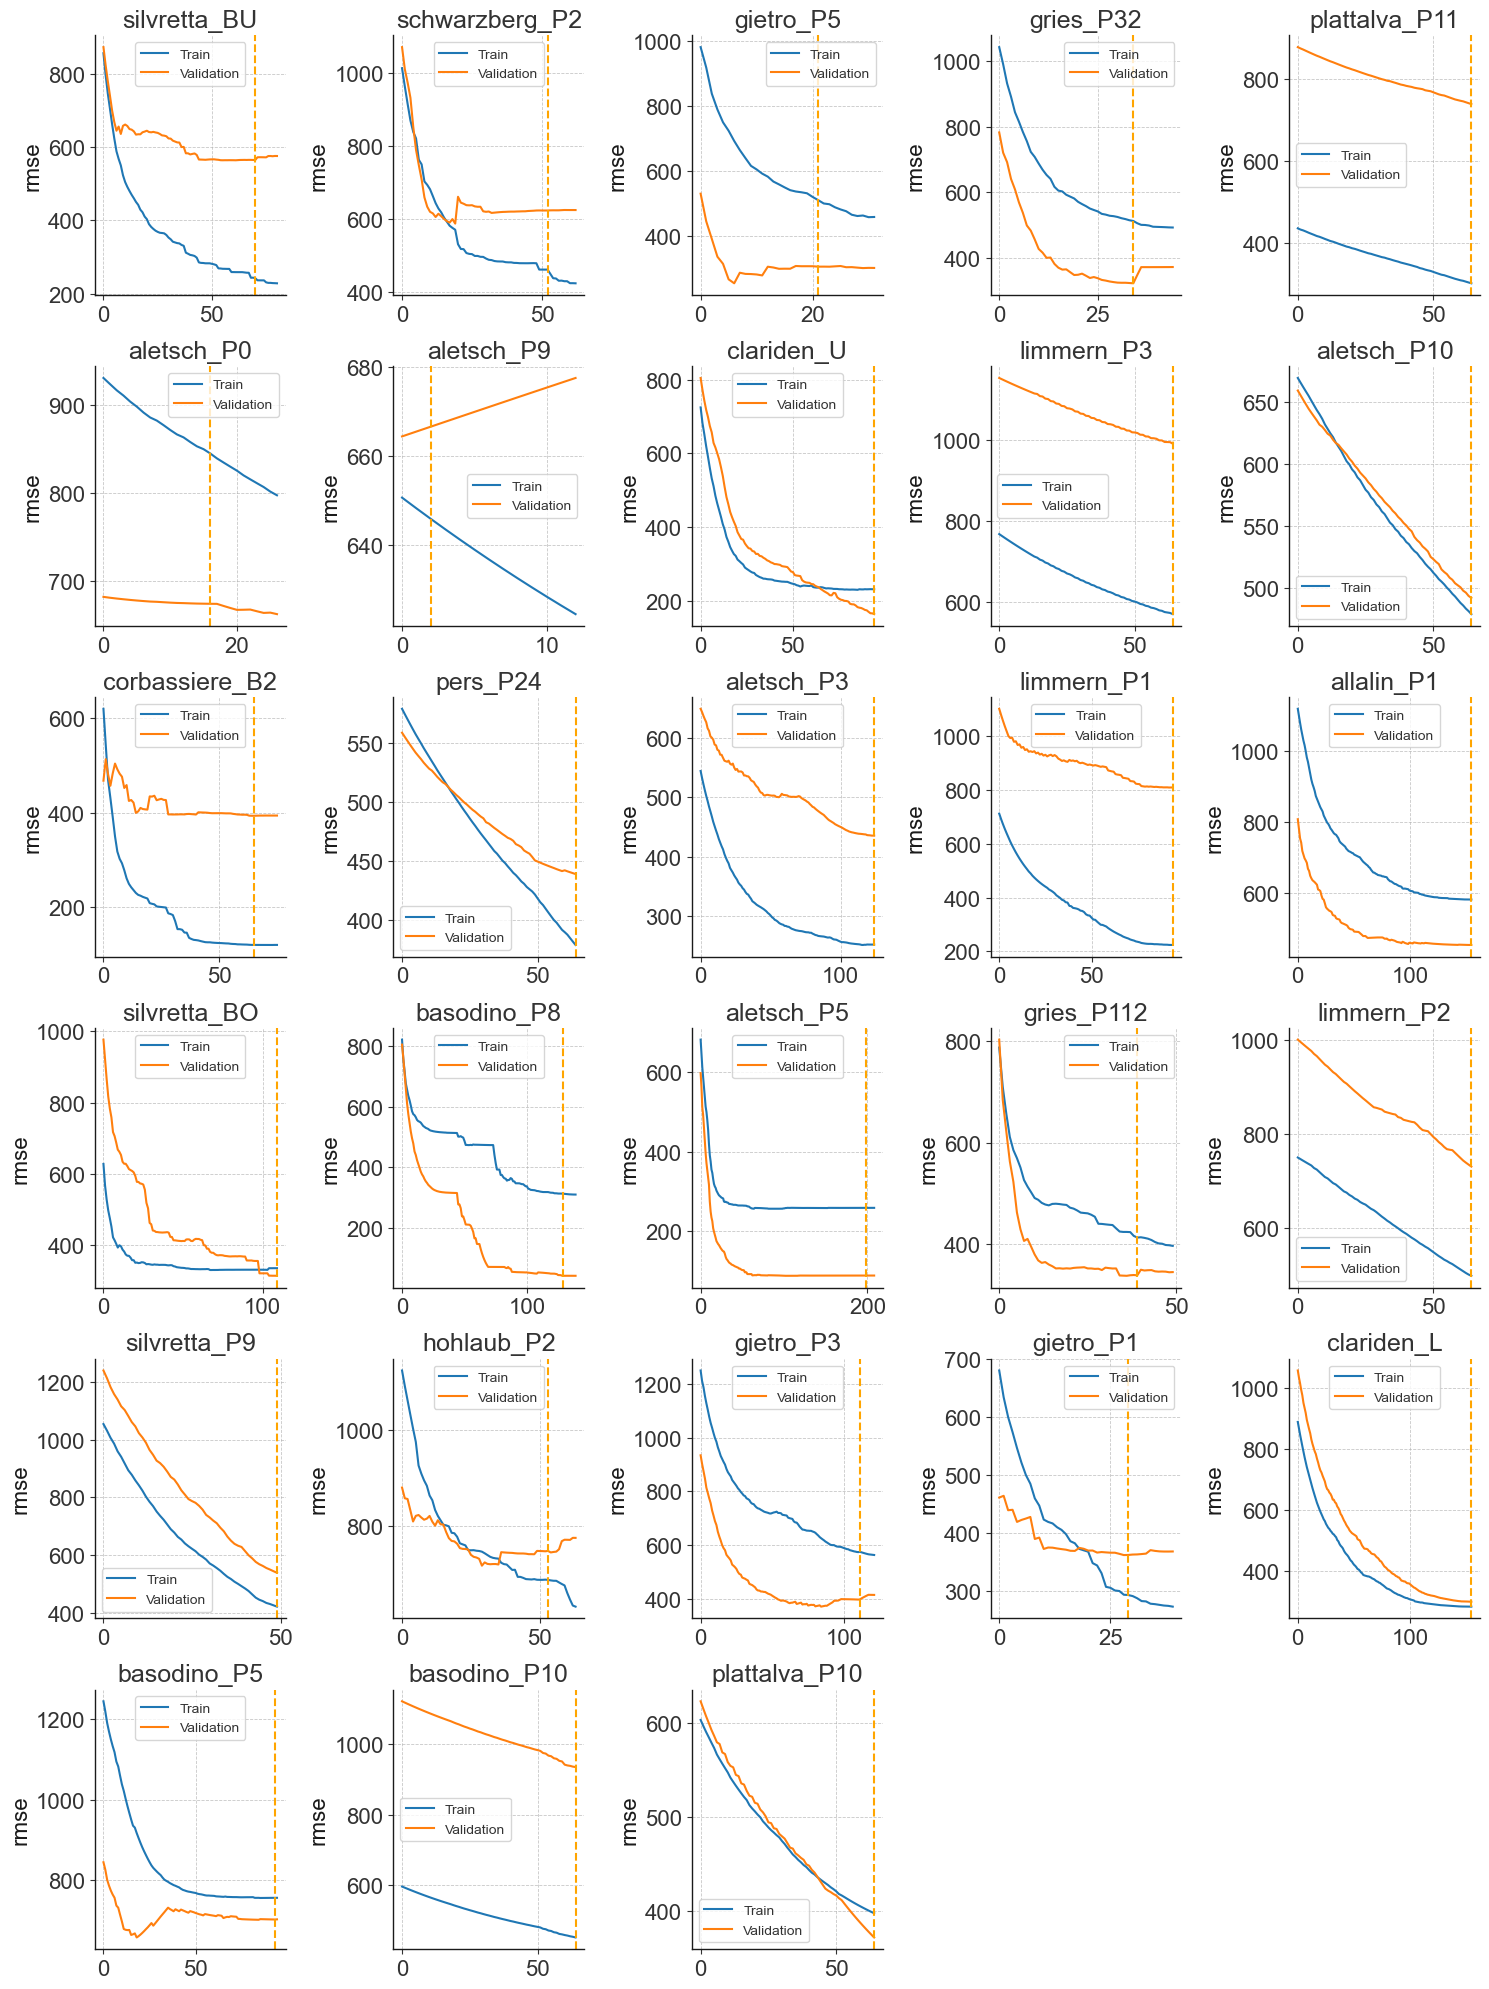

In [ ]:
stakes_processed = [
    re.split('var_', f)[1][:-4]
    for f in os.listdir(path_save_xgboost_stakes +
                        f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/')
    if f[:3] == 'var'
]
M, N = 6, 5
fig = plt.figure(figsize=(15, 20))
metric = 'rmse'
path = path_save_xgboost_stakes + f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/'
for i, stake in enumerate(stakes_processed):
    with open(path + f"var_{stake}.pkl", 'rb') as fp:
        stake_pickle = pickle.load(fp)
    epochs = stake_pickle['epochs'][0]
    x_axis = range(0, epochs)

    ax = plt.subplot(M, N, i + 1)
    ax.plot(x_axis, stake_pickle['train_loss'][0][metric], label='Train')

    ax.plot(x_axis, stake_pickle['val_loss'][0][metric], label='Validation')
    ax.axvline(stake_pickle['best_it'][0], color='orange', linestyle='--')
    ax.legend()
    ax.set_ylabel(metric)
    ax.set_title(f'{stake}')
plt.tight_layout()
plt.show()

###  Compare hyperparameters:

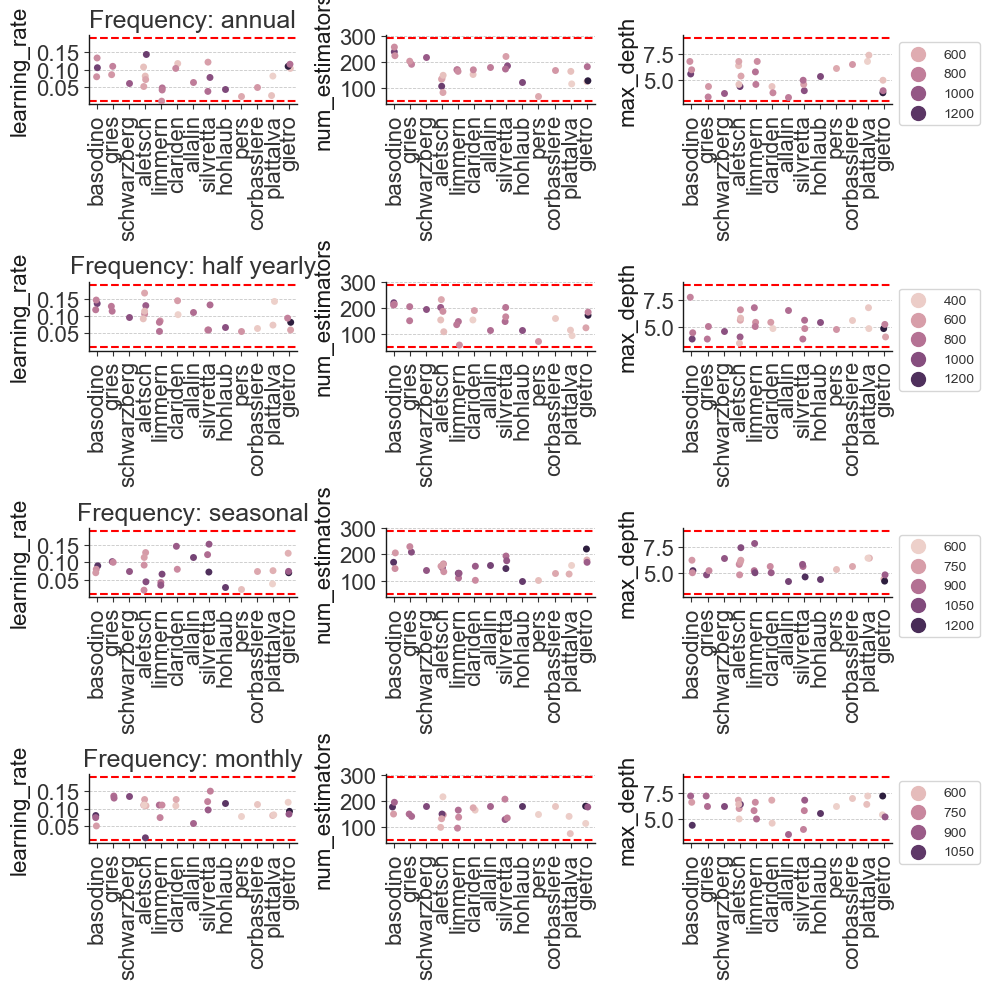

In [ ]:
fig = plt.figure(figsize=(10, 10))
N = 4
ax1 = plt.subplot(N, 3, 1)
ax2 = plt.subplot(N, 3, 2)
ax3 = plt.subplot(N, 3, 3)
plotHyperParam(metrics_annual, param_grid, ax1, ax2, ax3, freq='annual')

ax1 = plt.subplot(N, 3, 4)
ax2 = plt.subplot(N, 3, 5)
ax3 = plt.subplot(N, 3, 6)
plotHyperParam(metrics_half, param_grid, ax1, ax2, ax3, freq='half yearly')

ax1 = plt.subplot(N, 3, 7)
ax2 = plt.subplot(N, 3, 8)
ax3 = plt.subplot(N, 3, 9)
plotHyperParam(metrics_seasonal, param_grid, ax1, ax2, ax3, freq='seasonal')

ax1 = plt.subplot(N, 3, 10)
ax2 = plt.subplot(N, 3, 11)
ax3 = plt.subplot(N, 3, 12)
plotHyperParam(metrics_monthly, param_grid, ax1, ax2, ax3, freq='monthly')

plt.tight_layout()

### Compare temporal frequencies:

In [ ]:
color_palette = sns.color_palette("husl",
                                  len(df_metrics_monthly.glaciers.unique()))
colors = np.tile("#8CA6D9", len(var_xg_annual.keys()))
palette_grays = sns.color_palette(colors)

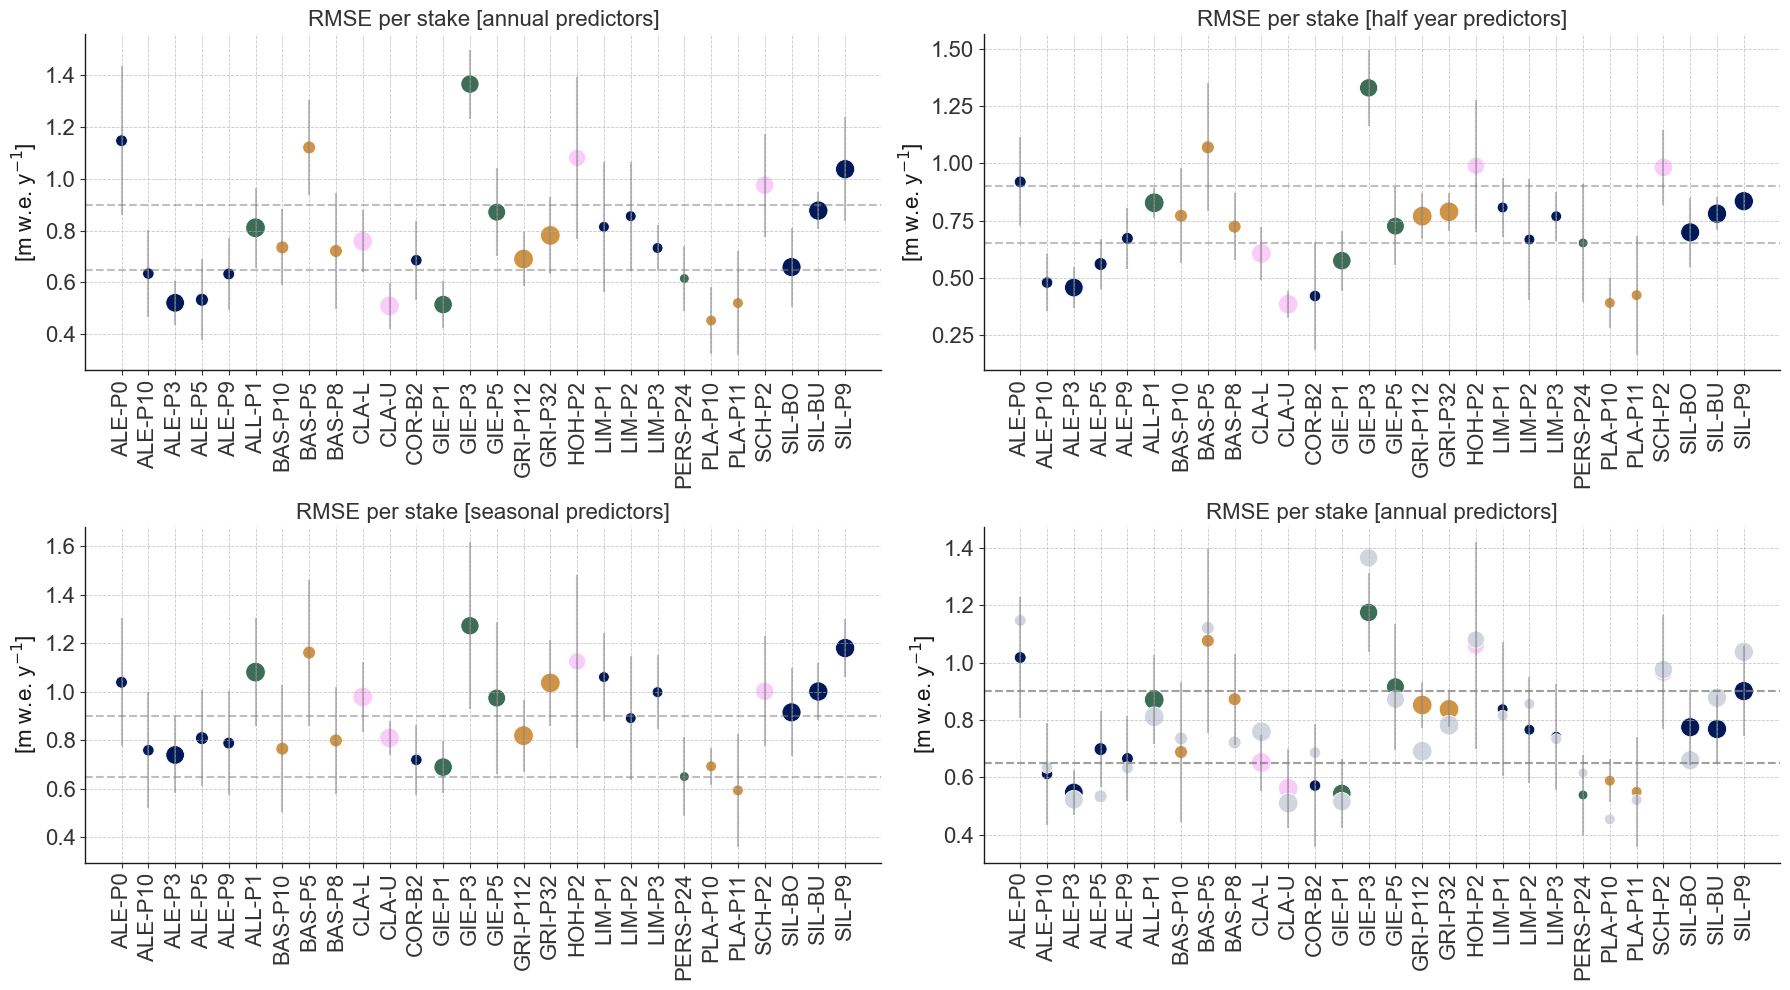

In [ ]:
cmap = cm.batlow
colors = get_cmap_hex(cmap, 4)
color_palette = sns.color_palette(colors)
plotCompareFreqs(df_metrics_annual, df_metrics_half, df_metrics_seasonal,
                 df_metrics_monthly, 'rmse_xgb', color_palette=color_palette)

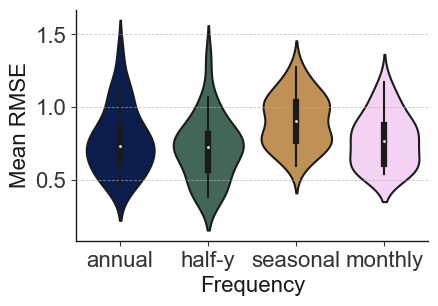

In [ ]:
ViolinPlotAnnToMonth(df_metrics_annual,
                     df_metrics_half,
                     df_metrics_seasonal,
                     df_metrics_monthly,
                     model='xgb')

#### Single stakes:

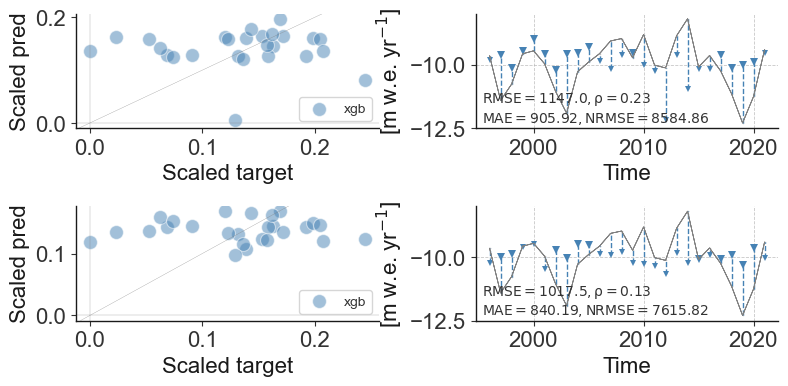

In [ ]:
stake = 'aletsch_P0'
fig = plt.figure(figsize=(8, 4))
palette_grays = sns.color_palette(np.tile("#8CA6D9",
                                          len(var_xg_annual.keys())))

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)

plotSingleStake(stake,
                var_xg_annual,
                metrics_annual,
                ax1,
                ax2,
                freq='annual',
                color='steelblue',
                kfold=KFOLD,
                scaled=True)

ax1 = plt.subplot(2, 2, 3)
ax2 = plt.subplot(2, 2, 4)

plotSingleStake(stake,
                var_xg_monthly,
                metrics_monthly,
                ax1,
                ax2,
                kfold=KFOLD,
                freq='monthly',
                color='steelblue',
                scaled=True)

plt.tight_layout()

### Feature importance of different frequencies:

In [ ]:
# Annual match
feature_list_monthly = [
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep'
]
feature_list_annual = ['tp_ann', 't2m_ann']

feature_list_halfyear = ['why_prec', 'shy_prec', 'why_temp', 'shy_temp']
seasons = {1: "winter", 2: "spring", 3: "summer", 4: "fall"}
feature_list_seasonal = np.concatenate([
    [f"prec_{seasons[i]}" for i in range(1, 5)],
    [f"temp_{seasons[i]}" for i in range(1, 5)],
])
df_total_annual = df_metrics_annual.groupby(['glaciers',
                                             'stakes']).mean().reset_index()
df_total_seasonal = df_metrics_seasonal.groupby(['glaciers', 'stakes'
                                                 ]).mean().reset_index()
df_total_halfy = df_metrics_half.groupby(['glaciers',
                                          'stakes']).mean().reset_index()

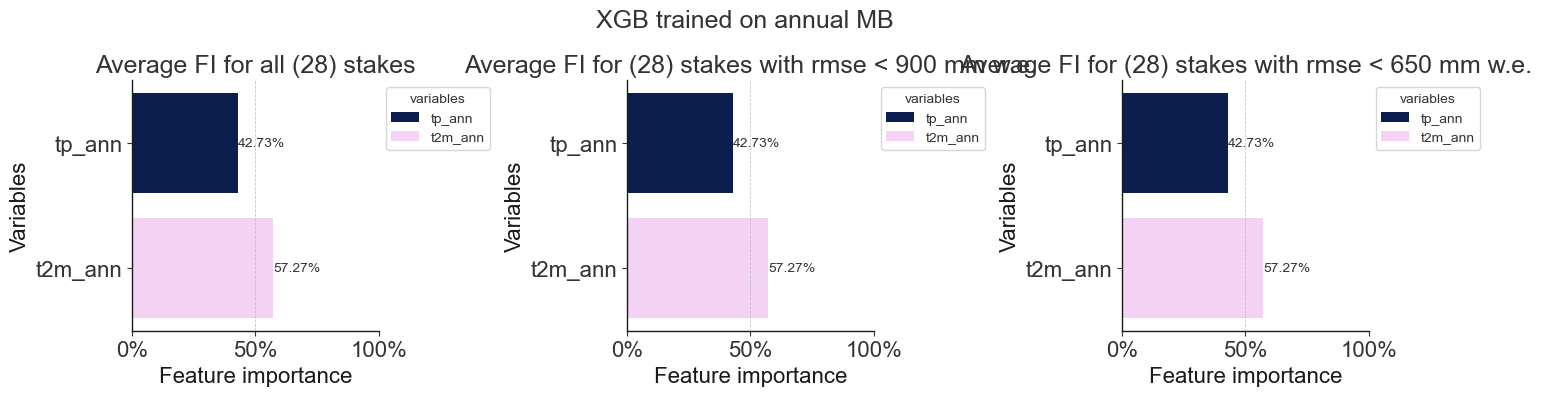

In [ ]:
plotFIBest(df_total_annual,
           var_xg_annual,
           feature_list_annual,
           metric='rmse_xgb',
           freq='annual')

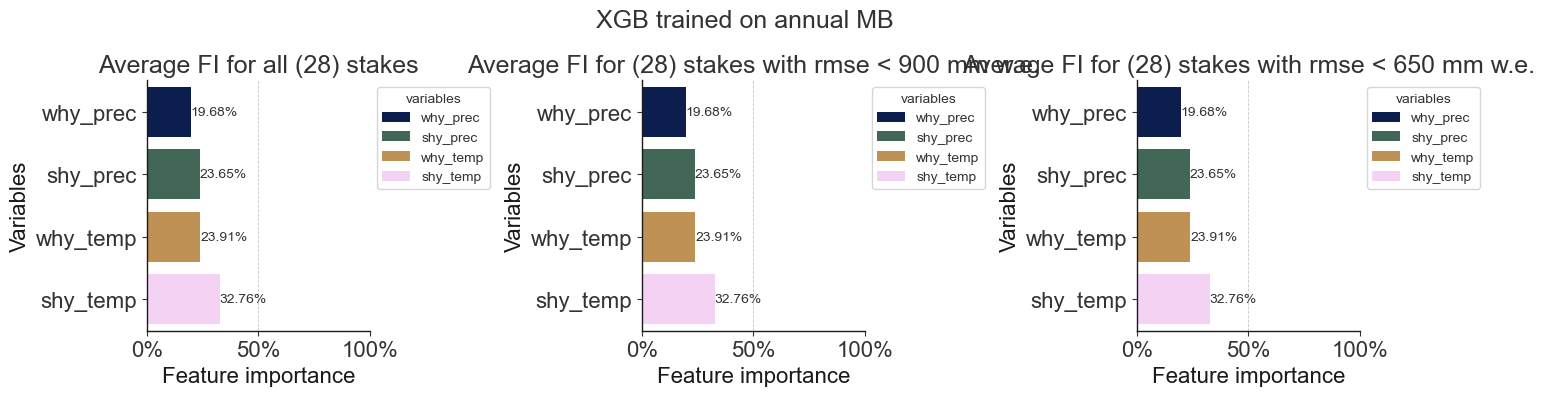

In [ ]:
plotFIBest(df_total_halfy,
           var_xg_half,
           feature_list_halfyear,
           metric='rmse_xgb',
           freq='halfy')

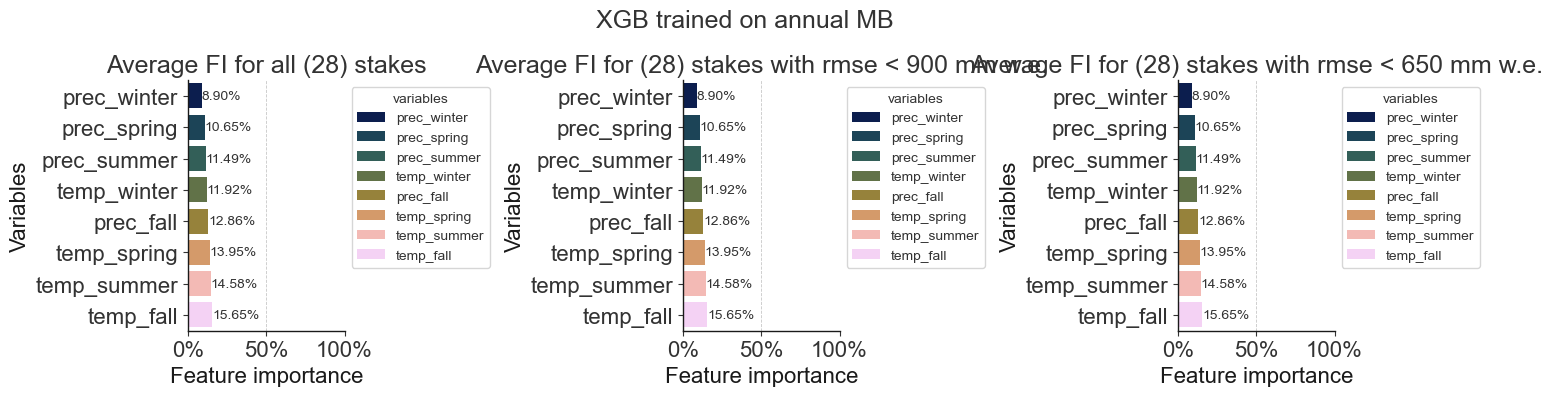

In [ ]:
plotFIBest(df_total_seasonal,
           var_xg_seasonal,
           feature_list_seasonal,
           metric='rmse_xgb',
           freq='seasonal')

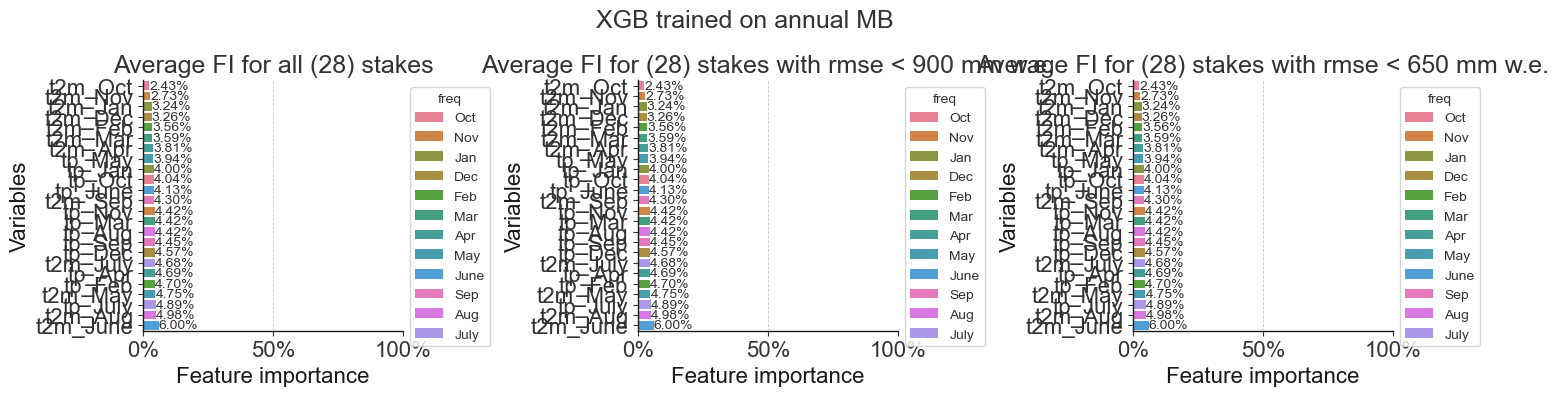

In [ ]:
plotFIBest(df_total_seasonal,
           var_xg_monthly,
           feature_list_monthly,
           metric='rmse_xgb',
           freq='monthly')

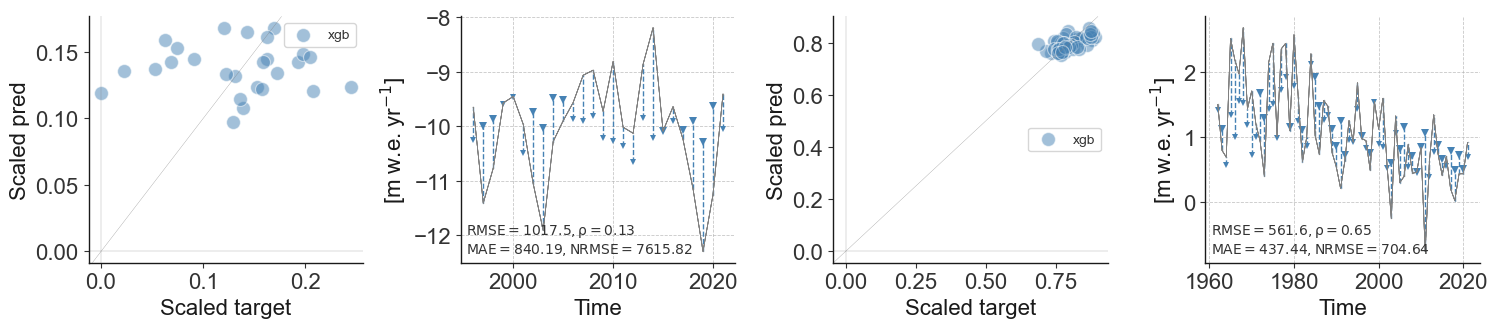

In [ ]:
stakes_good = df_metrics_monthly[df_metrics_monthly.mae_xgb < 600].stakes
glaciers_good = df_metrics_monthly[df_metrics_monthly.mae_xgb < 600].glaciers

stakes = ['aletsch_P0', 'clariden_U']
PlotCompare2Stakes(var_xg_monthly, metrics_monthly, stakes, KFOLD)